## Inputs

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy.optimize import curve_fit
import datetime
from netCDF4 import Dataset

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# subfunctions
def calculateVeer(heights,wind_direction,limits):
    xdata = heights
    ydata = wind_direction-wind_direction[0]
    for j in range(len(ydata))[1:]:
        temp1 = ydata[j]
        temp2 = ydata[j] + 360
        temp3 = ydata[j] - 360
        tempvector = [temp1,temp2,temp3]
        tempvector_absolute = np.absolute(tempvector)    
        min_value = min(tempvector_absolute) 
        min_index = np.nonzero(tempvector_absolute == min_value)
        temp = np.asarray(min_index[0])
        ydata[j] = tempvector[temp[0]]
    
    def func(x, a, b):
        return a*x+b
    popt, pcov = curve_fit(func, xdata, ydata)
    residuals = ydata- func(xdata, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    veer = func(limits[1], *popt)-func(limits[0], *popt)
    veer_rsquared = r_squared
    
    return veer, veer_rsquared

def calculateShear(heights,wind_speed): #(based on power-law assumption, could also calculate locally at hub-height, based on /projects/AWAKEN/lcheung/awaken.github/naluhelperscripts/plotABLstats.py)
    xdata = heights
    ydata = wind_speed
    def func(x, a, b):
        return b*x**a
    popt, pcov = curve_fit(func, xdata, ydata)
    residuals = ydata- func(xdata, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    shear = popt[0]
    shear_rsquared = r_squared
    
    return shear, shear_rsquared
    
def calculateLLJflag(heights,wind_speed): # see Debnath et al. (2021)
    xdata = heights
    ydata = wind_speed
    maxi = np.where(ydata == np.max(ydata))[0][0]
    if ydata[-1] != ydata[maxi]:
        deltaU_drop = ydata[maxi] - np.min(ydata[maxi:])
        deltaU_drop_over_U_nose = deltaU_drop/ydata[maxi]
        if deltaU_drop >= 1.5 and deltaU_drop_over_U_nose >= 0.1:
            LLJ_flag = 1
        else:
            LLJ_flag = 0
    else:
        LLJ_flag = 0

    return LLJ_flag

In [3]:
# load data
ds_raw = pd.read_csv(r'./E06_Hudson_South_10_min_avg_20190904_20220327/E06_Hudson_South_10_min_avg_20190904_20220327.csv',na_values=['   NaN'])
#print(ds_raw.variables.keys()) # get all variable names

In [4]:
# extract specific info from dataframe
wind_direction = ds_raw.filter(like='WD_alg_03').to_numpy()
wind_speed = ds_raw.filter(like='Z10_HorizWS').to_numpy()
turbulence_intensity = ds_raw.filter(like='StdDevWS').to_numpy()/wind_speed
pressure = ds_raw.filter(like='Pa_avg').to_numpy(); print('Median pressure of all data: '+str(np.nanmedian(pressure)))
temperature = ds_raw.filter(like='Ta_avg').to_numpy(); print('Median temperature of all data: '+str(np.nanmedian(temperature)))

Median pressure of all data: 1017.13
Median temperature of all data: 11.32


In [5]:
# set turbine parameters (for IEA 15 MW)
D = 240 # m 
H = 150 # m
height_rotorTop = H + D/2
height_rotorBot = H - D/2
heights_fullrotor = np.linspace(height_rotorTop,height_rotorBot,20) 

# set lidar parameters
heights = np.linspace(20,200,10) 

In [6]:
# set filters for cases of interest
wd_range               = [0,360]
ws_range               = [8.5,9.5]
ti_range               = [0.0,0.05]
veer_range             = [-np.inf,np.inf]
veer_rsquared_range    = [-np.inf,np.inf]
shear_range            = [-np.inf,np.inf]
shear_rsquared_range   = [0.5,1]
LLJ_flag_range         = [-np.inf,np.inf]

In [7]:
# set plot parameters
binNums = 30

In [8]:
# save details
savefolder = 'Plots'
savename = 'MedWS_LowTI'

## Preprocess

In [9]:
# calculate hub-height wind direction
wind_direction_hh = np.empty((len(wind_direction[:,1]),1))
for j in range(len(wind_direction[:,1])):
    allowableHeightDiff = 10. # plus or minus 10 m means that two heights will be interpolated
    mask = (~np.isnan(wind_direction[j,:])) & (np.abs(heights-H)<=allowableHeightDiff)
    if mask.sum()>1:
        measurementsSurroundingHubHeight = wind_direction[j,mask]
        # calculate hub-height wind direction accounting for the discontinuity from 0/360 deg (HARDCODED WARNING: THIS ASSUMES THAT HUB HEIGHT IS EXACTLY BETWEEN THE TWO MEASUREMENT POINTS WHICH IS TRUE HERE AS CODED BUT WILL NOT BE GENERALLY TRUE)
        temp1 = measurementsSurroundingHubHeight[1]-measurementsSurroundingHubHeight[0]
        temp2 = measurementsSurroundingHubHeight[1]-measurementsSurroundingHubHeight[0] + 360
        temp3 = measurementsSurroundingHubHeight[1]-measurementsSurroundingHubHeight[0] - 360
        tempvector = [temp1,temp2,temp3]
        tempvector_absolute = np.absolute(tempvector)
        min_value = min(tempvector_absolute) 
        min_index = np.nonzero(tempvector_absolute == min_value)
        temp = np.asarray(min_index[0])           
        if temp[0]==0:
            wind_direction_hh[j] = (measurementsSurroundingHubHeight[1]+measurementsSurroundingHubHeight[0])/2.
        elif temp[0]==1:
            wind_direction_hh[j] = (measurementsSurroundingHubHeight[1]+measurementsSurroundingHubHeight[0] + 360)/2.
        elif temp[0]==2:
            wind_direction_hh[j] = (measurementsSurroundingHubHeight[1]+measurementsSurroundingHubHeight[0] - 360)/2.
        # adjust to be within [0,360] deg, if necessary
        if wind_direction_hh[j]>360:
            wind_direction_hh[j] = wind_direction_hh[j] - 360
        elif wind_direction_hh[j]<0:
            wind_direction_hh[j] = wind_direction_hh[j] + 360
    else:
        wind_direction_hh[j] = float("NaN")

# calculate hub-height wind speed
wind_speed_hh = np.empty((len(wind_speed[:,1]),1))
for j in range(len(wind_speed[:,1])):
    allowableHeightDiff = 30. # HARDCODED WARNING: plus or minus 30 m means that four heights will be interpolated for this case though that won't be true in general
    mask = (~np.isnan(wind_speed[j,:])) & (np.abs(heights-H)<=allowableHeightDiff)
    if mask.sum()>3:
        # calculate hub-height wind speed
        interp = interpolate.interp1d(heights[mask], wind_speed[j,mask], kind = "quadratic")
        wind_speed_hh[j] = interp(H)   
    else:
        wind_speed_hh[j] = float("NaN")

# calculate hub-height TI
turbulence_intensity_hh = np.empty((len(turbulence_intensity[:,1]),1))
for j in range(len(turbulence_intensity[:,1])):
    allowableHeightDiff = 30. # HARDCODED WARNING: plus or minus 30 m means that four heights will be interpolated for this case though that won't be true in general
    mask = (~np.isnan(turbulence_intensity[j,:])) & (np.abs(heights-H)<=allowableHeightDiff)
    if mask.sum()>3:
        # calculate hub-height TI
        interp = interpolate.interp1d(heights[mask], turbulence_intensity[j,mask], kind = "quadratic")
        turbulence_intensity_hh[j] = interp(H)   
    else:
        turbulence_intensity_hh[j] = float("NaN")

# calculate veer
veer = np.empty((len(wind_direction[:,1]),1))
veer_rsquared = np.empty((len(wind_direction[:,1]),1))
for j in range(len(wind_direction[:,1])):
    mask = (~np.isnan(wind_direction[j,:]))
    if mask.sum()>0.5*len(heights):
        limits = [height_rotorBot, height_rotorTop]
        veer[j], veer_rsquared[j] = calculateVeer(heights[mask],wind_direction[j,mask],limits)
    else:
        veer[j] = float("NaN")
      
# calculate shear
shear = np.empty((len(wind_speed[:,1]),1))
shear_rsquared = np.empty((len(wind_speed[:,1]),1))
for j in range(len(wind_speed[:,1])):
    mask = (~np.isnan(wind_speed[j,:]))
    if mask.sum()>0.5*len(heights) and ~np.isnan(wind_speed_hh[j]):
        try:
            shear[j], shear_rsquared[j] = calculateShear(heights[mask],wind_speed[j,mask])  # calculateShear(heights[mask]/H,wind_speed[j,mask]/wind_speed_hh[j])
        except:
            shear[j] = float("NaN")
    else:
        shear[j] = float("NaN")

# calculate LLJ flag (based on Debnath et al. (2021))
LLJ_flag = np.empty((len(wind_speed[:,1]),1))
for j in range(len(wind_speed[:,1])):
    mask = (~np.isnan(wind_speed[j,:]))
    if mask.sum()>0.5*len(heights) and ~np.isnan(wind_speed_hh[j]):
        LLJ_flag[j] = calculateLLJflag(heights[mask],wind_speed[j,mask])
    else:
        LLJ_flag[j] = float("NaN")

In [10]:
# calculated centered wind direction (i.e., centered on hub-height wind direction)
wind_direction_centered = np.empty(np.shape(wind_direction))
for j in range(len(wind_direction[:,1])):
    wind_direction_centered[j,:] = wind_direction[j,:]-wind_direction_hh[j]
    for i in range(len(wind_direction_centered[j,:])):
        if wind_direction_centered[j,i]<-180:
            wind_direction_centered[j,i] = wind_direction_centered[j,i] + 360
        elif wind_direction_centered[j,i]>180:
            wind_direction_centered[j,i] = wind_direction_centered[j,i] - 360

## Plot All Data

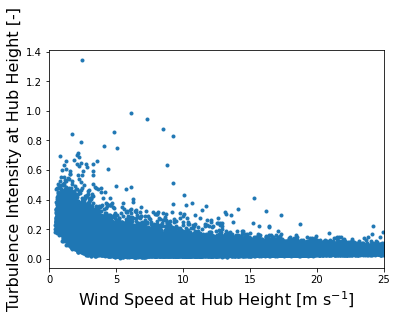

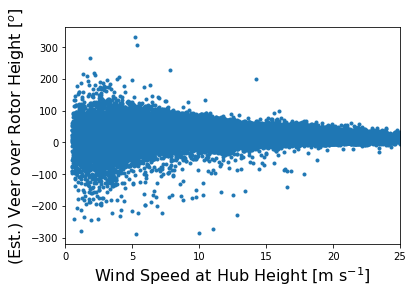

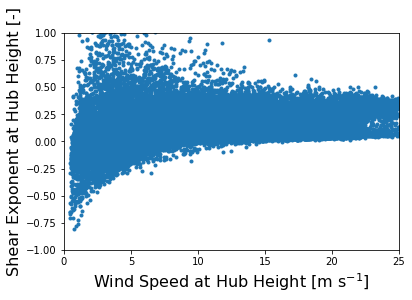

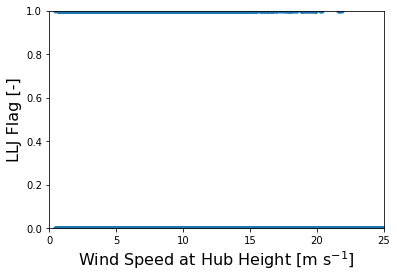

In [11]:
# plot TI vs wind speed
plt.figure()
plt.plot(wind_speed_hh, turbulence_intensity_hh, marker = '.', linestyle = 'none')
plt.xlabel('Wind Speed at Hub Height [m s$^{-1}$]', fontsize = 16)
plt.ylabel('Turbulence Intensity at Hub Height [-]', fontsize = 16)
plt.xlim([0, 25])
#plt.ylim([0, 180])
plt.show()

# plot veer vs wind speed
plt.figure()
plt.plot(wind_speed_hh, veer, marker = '.', linestyle = 'none')
plt.xlabel('Wind Speed at Hub Height [m s$^{-1}$]', fontsize = 16)
plt.ylabel('(Est.) Veer over Rotor Height [$^o$]', fontsize = 16)
plt.xlim([0, 25])
#plt.ylim([0, 180])
plt.show()

# plot shear vs wind speed
plt.figure()
plt.plot(wind_speed_hh, shear, marker = '.', linestyle = 'none')
plt.xlabel('Wind Speed at Hub Height [m s$^{-1}$]', fontsize = 16)
plt.ylabel('Shear Exponent at Hub Height [-]', fontsize = 16)
plt.xlim([0, 25])
plt.ylim([-1, 1])
plt.show()

# plot LLJ flag vs wind speed
plt.figure()
plt.plot(wind_speed_hh, LLJ_flag, marker = '.', linestyle = 'none')
plt.xlabel('Wind Speed at Hub Height [m s$^{-1}$]', fontsize = 16)
plt.ylabel('LLJ Flag [-]', fontsize = 16)
plt.xlim([0, 25])
plt.ylim([0, 1])
plt.show()

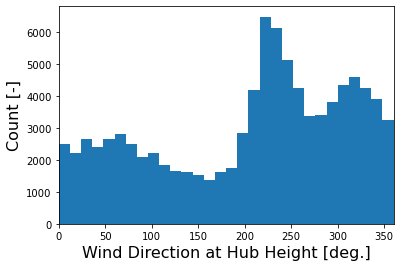

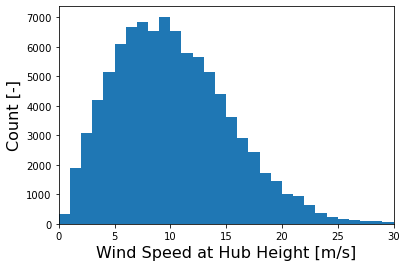

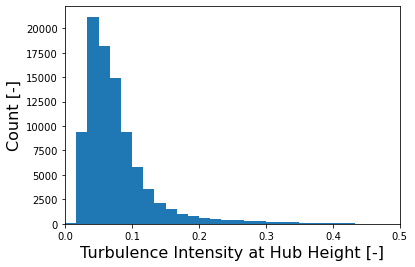

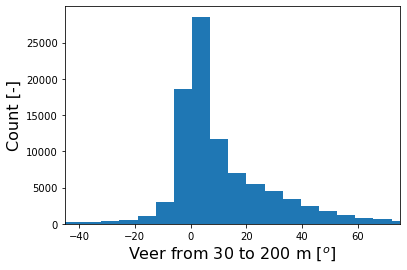

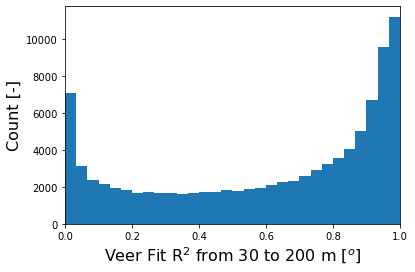

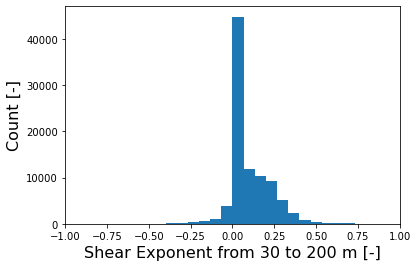

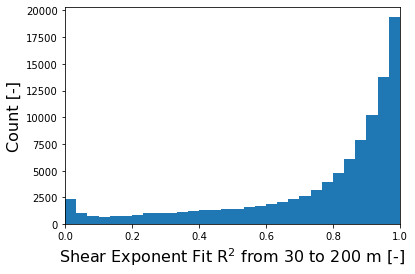

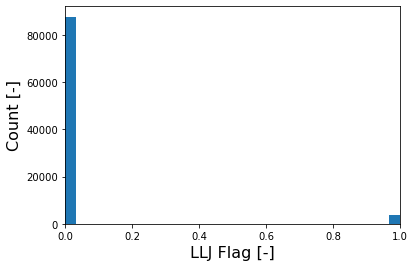

In [12]:
# plot hub-height wind direction histogram
plt.figure()
plt.hist(wind_direction_hh[~np.isnan(wind_direction_hh)],binNums,range=[0, 360]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why you must specify range or remove nans using "hist"
plt.xlabel('Wind Direction at Hub Height [deg.]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 360])
#plt.ylim([0, 180])
plt.show()

# plot hub-height wind speed histogram
plt.figure()
plt.hist(wind_speed_hh[~np.isnan(wind_speed_hh)],binNums,range=[0, 30])
plt.xlabel('Wind Speed at Hub Height [m/s]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 30])
#plt.ylim([0, 180])
plt.show()

# plot hub-height TI histogram
plt.figure()
plt.hist(turbulence_intensity_hh[~np.isnan(turbulence_intensity_hh)],binNums,range=[0, 0.5])
plt.xlabel('Turbulence Intensity at Hub Height [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 0.5])
#plt.ylim([0, 180])
plt.show()

# plot veer histogram
plt.figure()
plt.hist(veer[~np.isnan(veer)],binNums,range=[-45, 150]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('Veer from 30 to 200 m [$^o$]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([-45, 75])
#plt.ylim([0, 180])
plt.show()

# plot veer rsquared histogram
plt.figure()
plt.hist(veer_rsquared[~np.isnan(veer_rsquared)],binNums,range=[0, 1]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('Veer Fit R$^{2}$ from 30 to 200 m [$^o$]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 1])
#plt.ylim([0, 180])
plt.show()

# plot shear exponent histogram
plt.figure()
plt.hist(shear[~np.isnan(shear)],binNums,range=[-1, 1]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('Shear Exponent from 30 to 200 m [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([-1, 1])
#plt.ylim([0, 180])
plt.show()

# plot shear exponent rsquared histogram
plt.figure()
plt.hist(shear_rsquared[~np.isnan(shear_rsquared)],binNums,range=[0, 1]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('Shear Exponent Fit R$^{2}$ from 30 to 200 m [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 1])
#plt.ylim([0, 180])
plt.show()

# plot LLJ flag histogram
plt.figure()
plt.hist(LLJ_flag[~np.isnan(LLJ_flag)],binNums,range=[0, 1]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('LLJ Flag [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 1])
#plt.ylim([0, 180])
plt.show()

## Filter cases of specific interest

In [13]:
# calculate percent retained data
keepIndex = []
for j in range(len(wind_speed_hh)):
    if wind_speed_hh[j] >= ws_range[0] and wind_speed_hh[j] <= ws_range[1] and \
       turbulence_intensity_hh[j] >= ti_range[0] and turbulence_intensity_hh[j] <= ti_range[1] and \
       wind_direction_hh[j] >= wd_range[0] and wind_direction_hh[j] <= wd_range[1] and \
       veer[j] >= veer_range[0] and veer[j] <= veer_range[1] and \
       veer_rsquared[j] >= veer_rsquared_range[0] and veer_rsquared[j] <= veer_rsquared_range[1] and \
       shear[j] >= shear_range[0] and shear[j] <= shear_range[1] and \
       shear_rsquared[j] >= shear_rsquared_range[0] and shear_rsquared[j] <= shear_rsquared_range[1] and \
       LLJ_flag[j] >= LLJ_flag_range[0] and LLJ_flag[j] <= LLJ_flag_range[1]:
        keepIndex.append(j)
print('Retain '+str(100.*len(keepIndex)/((~np.isnan(wind_speed_hh)) & (~np.isnan(wind_direction_hh)) & (~np.isnan(turbulence_intensity_hh)) & (~np.isnan(veer)) & (~np.isnan(veer_rsquared)) & (~np.isnan(shear)) & (~np.isnan(shear_rsquared)) & (~np.isnan(LLJ_flag))).sum())+' percent of original data')

# for reference calculate the percent of retained data within the limits of only ws_range
keepIndex_onlyws = []
for j in range(len(wind_speed_hh)):
    if wind_speed_hh[j] >= ws_range[0] and wind_speed_hh[j] <= ws_range[1]:
        keepIndex_onlyws.append(j)
print('Retain '+str(100.*len(keepIndex)/((~np.isnan(wind_speed_hh[keepIndex_onlyws])) & (~np.isnan(wind_direction_hh[keepIndex_onlyws])) & (~np.isnan(turbulence_intensity_hh[keepIndex_onlyws])) & (~np.isnan(veer[keepIndex_onlyws])) & (~np.isnan(veer_rsquared[keepIndex_onlyws])) & (~np.isnan(shear[keepIndex_onlyws])) & (~np.isnan(shear_rsquared[keepIndex_onlyws])) & (~np.isnan(LLJ_flag[keepIndex_onlyws]))).sum())+' percent of original data within bounds of ws_range')

# for reference calculate the percent of retained data within the limits of only ws_range and ti_range
keepIndex_onlywsANDti = []
for j in range(len(wind_speed_hh)):
    if wind_speed_hh[j] >= ws_range[0] and wind_speed_hh[j] <= ws_range[1] and \
       turbulence_intensity_hh[j] >= ti_range[0] and turbulence_intensity_hh[j] <= ti_range[1]: 
        keepIndex_onlywsANDti.append(j)
print('Retain '+str(100.*len(keepIndex)/((~np.isnan(wind_speed_hh[keepIndex_onlywsANDti])) & (~np.isnan(wind_direction_hh[keepIndex_onlywsANDti])) & (~np.isnan(turbulence_intensity_hh[keepIndex_onlywsANDti])) & (~np.isnan(veer[keepIndex_onlywsANDti])) & (~np.isnan(veer_rsquared[keepIndex_onlywsANDti])) & (~np.isnan(shear[keepIndex_onlywsANDti])) & (~np.isnan(shear_rsquared[keepIndex_onlywsANDti])) & (~np.isnan(LLJ_flag[keepIndex_onlywsANDti]))).sum())+' percent of original data within bounds of ws_range and ti_range')

print('Total bins retained '+str(len(keepIndex)))

Retain 2.331387772533646 percent of original data
Retain 32.18929543392803 percent of original data within bounds of ws_range
Retain 88.12086092715232 percent of original data within bounds of ws_range and ti_range
Total bins retained 2129


## Calculate mean values

In [14]:
# calculate mean summary stats
print('Wind speed target: '+str(np.average(wind_speed_hh[keepIndex])))
print('TI target: '+str(np.average(turbulence_intensity_hh[keepIndex])))
print('Shear target: '+str(np.average(shear[keepIndex]))+' (calculated from mean of shear exponents of each filtered case)')
print('Veer target: '+str(np.average(veer[keepIndex]))+' (calculated from mean of veer of each filtered case)')
print('rho: '+str(np.average(100*pressure[keepIndex]/(287.058*(temperature[keepIndex]+273.15)))))

Wind speed target: 9.026069636566463
TI target: 0.037090033630552535
Shear target: 0.1710809237295463 (calculated from mean of shear exponents of each filtered case)
Veer target: 21.34560791664837 (calculated from mean of veer of each filtered case)
rho: 1.2266404124721237


In [15]:
# calculate mean profiles
WS_mean = []
WDC_mean = []
TI_mean = []
for k in range(len(wind_speed[0,:])):
    WS_mean.append(np.nanmean(wind_speed[keepIndex,k]))
    #WD_mean.append(np.nanmean(wind_direction[keepIndex,k])) # note this doesn't handle 0/360 crossover cases
    WDC_mean.append(np.nanmean(wind_direction_centered[keepIndex,k]))
    TI_mean.append(np.nanmean(turbulence_intensity[keepIndex,k]))
WS_mean = np.array(WS_mean)
WDC_mean = np.array(WDC_mean)
TI_mean = np.array(TI_mean)

In [16]:
# Save the data
np.savetxt('MedWS_LowTI_heights.dat', heights)
np.savetxt('MedWS_LowTI_WSmean.dat', WS_mean)
np.savetxt('MedWS_LowTI_WDCmean.dat', WDC_mean)
np.savetxt('MedWS_LowTI_TImean.dat', TI_mean)

## Plot filtered data

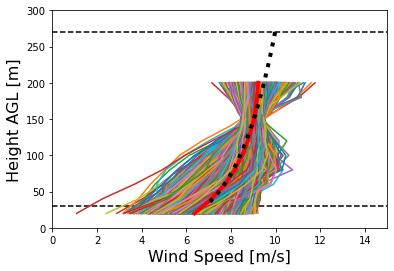

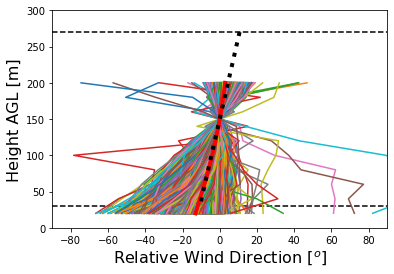

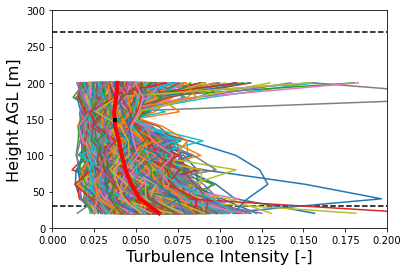

In [17]:
# plot wind speed traces
plt.figure()
plt.plot([0,15],[H+D/2,H+D/2], color = 'k', marker = '', linestyle = '--')
plt.plot([0,15],[H-D/2,H-D/2], color = 'k', marker = '', linestyle = '--')
for j in range(len(keepIndex)):
    mask = ~ma.getmask(wind_speed[keepIndex[j],:])
    plt.plot(wind_speed[keepIndex[j],mask][0], heights[mask][0], marker = '', linestyle = 'solid', label="bin"+str(keepIndex[j]))
plt.plot(WS_mean[~np.isnan(WS_mean)], heights[~np.isnan(WS_mean)], color = 'r', marker = '', linestyle = '-', linewidth = 4, label="mean")
plt.plot(np.average(wind_speed_hh[keepIndex])*(heights_fullrotor/H)**np.average(shear[keepIndex]), heights_fullrotor, color = 'k', marker = '', linestyle = ':', linewidth = 4, label="derived")
plt.xlabel('Wind Speed [m/s]', fontsize = 16)
plt.ylabel('Height AGL [m]', fontsize = 16)
plt.xlim([0, 15])
plt.ylim([0, 300])
plt.savefig(savefolder+'/'+savename+'_'+'Trace_WS.svg', format='svg', dpi=600)
plt.show()

# plot wind direction traces
plt.figure()
plt.plot([-90,90],[H+D/2,H+D/2], color = 'k', marker = '', linestyle = '--')
plt.plot([-90,90],[H-D/2,H-D/2], color = 'k', marker = '', linestyle = '--')
for j in range(len(keepIndex)):
    mask = ~ma.getmask(wind_direction_centered[keepIndex[j],:])
    plt.plot(wind_direction_centered[keepIndex[j],mask][0], heights[mask][0], marker = '', linestyle = 'solid', label="bin"+str(keepIndex[j]))
plt.plot(WDC_mean[~np.isnan(WDC_mean)], heights[~np.isnan(WDC_mean)], color = 'r', marker = '', linestyle = '-', linewidth = 4, label="mean")
plt.plot((np.average(veer[keepIndex])/(height_rotorTop-height_rotorBot))*(heights_fullrotor-H), heights_fullrotor, color = 'k', marker = '', linestyle = ':', linewidth = 4, label="derived")
plt.xlabel('Relative Wind Direction [$^o$]', fontsize = 16)
plt.ylabel('Height AGL [m]', fontsize = 16)
plt.xlim([-90,90])
plt.ylim([0, 300])
plt.savefig(savefolder+'/'+savename+'_'+'Trace_WD.svg', format='svg', dpi=600)
plt.show()

# plot TI traces
plt.figure()
plt.plot([0,0.2],[H+D/2,H+D/2], color = 'k', marker = '', linestyle = '--')
plt.plot([0,0.2],[H-D/2,H-D/2], color = 'k', marker = '', linestyle = '--')
for j in range(len(keepIndex)):
    mask = ~ma.getmask(turbulence_intensity[keepIndex[j],:])
    plt.plot(turbulence_intensity[keepIndex[j],mask][0], heights[mask][0], marker = '', linestyle = 'solid', label="bin"+str(keepIndex[j]))
plt.plot(TI_mean[~np.isnan(TI_mean)], heights[~np.isnan(TI_mean)], color = 'r', marker = '', linestyle = '-', linewidth = 4, label="mean")
plt.plot(np.average(turbulence_intensity_hh[keepIndex]), H, color = 'k', marker = 's', markersize = 3, linestyle = '--', linewidth = 4, label="derived")
plt.xlabel('Turbulence Intensity [-]', fontsize = 16)
plt.ylabel('Height AGL [m]', fontsize = 16)
plt.xlim([0, 0.2])
plt.ylim([0, 300])
plt.savefig(savefolder+'/'+savename+'_'+'Trace_TI.svg', format='svg', dpi=600)
plt.show()

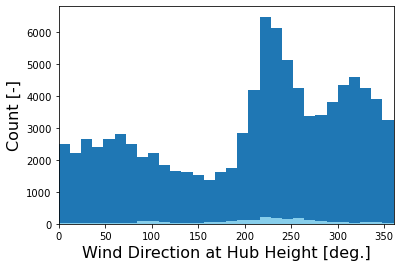

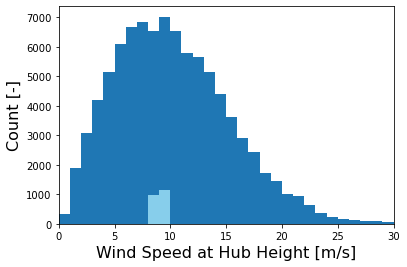

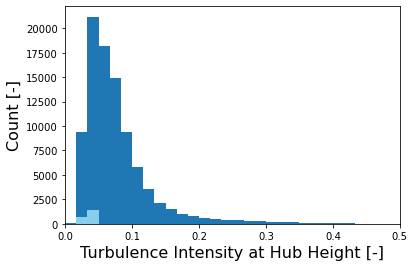

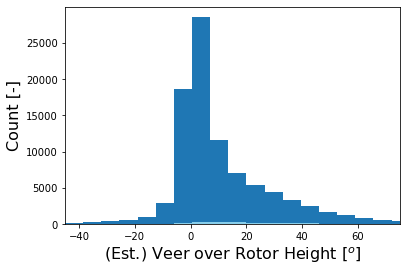

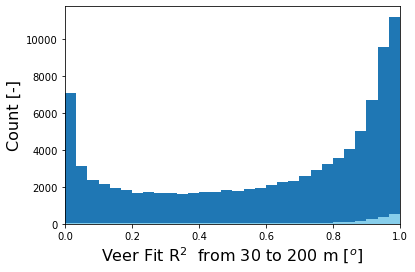

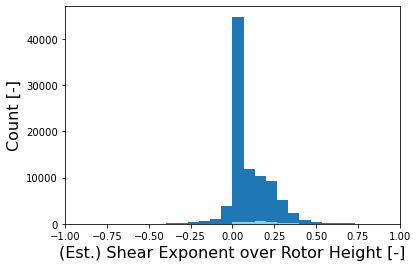

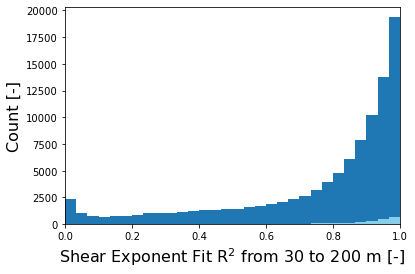

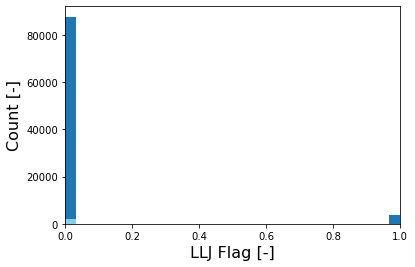

In [18]:
# highlight the filtered data in context of the full dataset

# plot hub-height wind direction histogram
plt.figure()
plt.hist(wind_direction_hh[~np.isnan(wind_direction_hh)],binNums,range=[0, 360],label = 'Full Dataset') # see https://github.com/matplotlib/matplotlib/issues/6483 for why you must specify range or remove nans using "hist"
plt.hist(wind_direction_hh[keepIndex],binNums,range=[0, 360],label = 'Filtered', color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why you must specify range or remove nans using "hist"
plt.xlabel('Wind Direction at Hub Height [deg.]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 360])
#plt.ylim([0, 180])
plt.show()

# plot hub-height wind speed histogram
plt.figure()
plt.hist(wind_speed_hh[~np.isnan(wind_speed_hh)],binNums,range=[0, 30],label = 'Full Dataset')
plt.hist(wind_speed_hh[keepIndex],binNums,range=[0, 30],label = 'Filtered', color='skyblue')
plt.xlabel('Wind Speed at Hub Height [m/s]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 30])
#plt.ylim([0, 180])
plt.show()

# plot hub-height TI histogram
plt.figure()
plt.hist(turbulence_intensity_hh[~np.isnan(turbulence_intensity_hh)],binNums,range=[0, 0.5],label = 'Full Dataset')
plt.hist(turbulence_intensity_hh[keepIndex],binNums,range=[0, 0.5],label = 'Filtered', color='skyblue')
plt.xlabel('Turbulence Intensity at Hub Height [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 0.5])
#plt.ylim([0, 180])
plt.show()

# plot veer histogram
plt.figure()
plt.hist(veer[~np.isnan(veer)],binNums,range=[-45, 150],label = 'Full Dataset') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(veer[keepIndex],binNums,range=[-45, 150],label = 'Filtered', color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('(Est.) Veer over Rotor Height [$^o$]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([-45, 75])
#plt.ylim([0, 180])
plt.show()

# plot veer rsquared histogram
plt.figure()
plt.hist(veer_rsquared[~np.isnan(veer_rsquared)],binNums,range=[0, 1],label = 'Full Dataset') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(veer_rsquared[keepIndex],binNums,range=[0, 1],label = 'Filtered', color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('Veer Fit R$^{2}$  from 30 to 200 m [$^o$]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 1])
#plt.ylim([0, 180])
plt.show()

# plot shear exponent histogram
plt.figure()
plt.hist(shear[~np.isnan(shear)],binNums,range=[-1, 1],label = 'Full Dataset') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(shear[keepIndex],binNums,range=[-1, 1],label = 'Filtered', color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('(Est.) Shear Exponent over Rotor Height [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([-1, 1])
#plt.ylim([0, 180])
plt.show()

# plot shear exponent rsquared histogram
plt.figure()
plt.hist(shear_rsquared[~np.isnan(shear_rsquared)],binNums,range=[0, 1],label = 'Full Dataset') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(shear_rsquared[keepIndex],binNums,range=[0, 1],label = 'Filtered', color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('Shear Exponent Fit R$^{2}$ from 30 to 200 m [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 1])
#plt.ylim([0, 180])
plt.show()

# plot LLJ flag histogram
plt.figure()
plt.hist(LLJ_flag[~np.isnan(LLJ_flag)],binNums,range=[0, 1],label = 'Full Dataset') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(LLJ_flag[keepIndex],binNums,range=[0, 1],label = 'Filtered', color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('LLJ Flag [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 1])
#plt.ylim([0, 180])
plt.show()

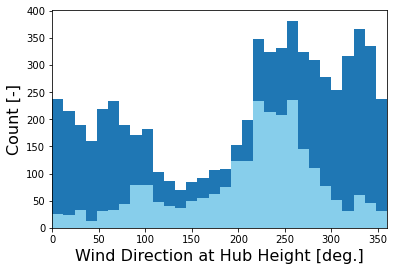

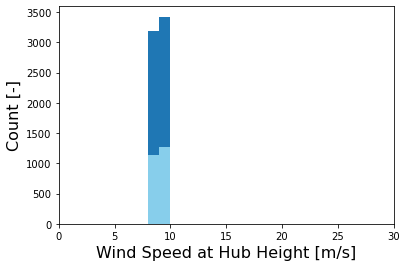

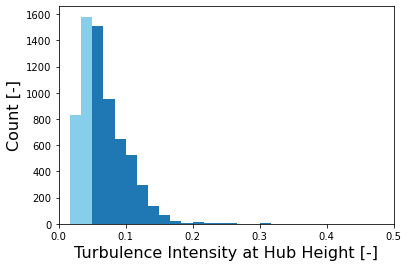

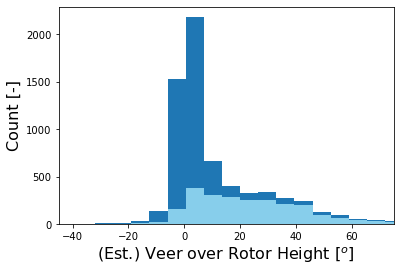

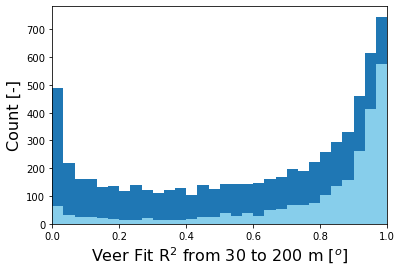

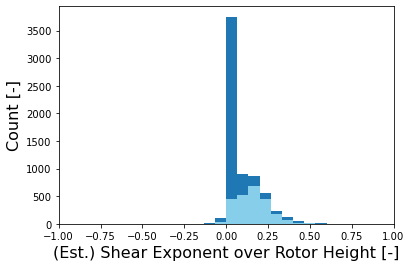

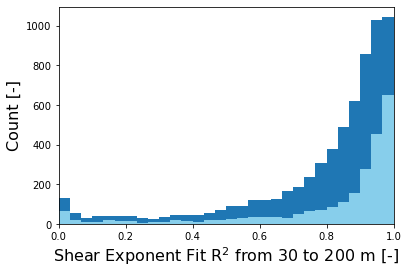

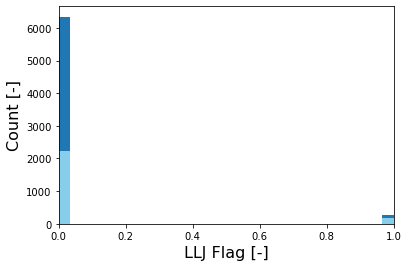

In [19]:
# highlight the data filtered by ti_range

# plot hub-height wind direction histogram
plt.figure()
plt.hist(wind_direction_hh[keepIndex_onlyws],binNums,range=[0, 360]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why you must specify range or remove nans using "hist"
plt.hist(wind_direction_hh[keepIndex_onlywsANDti],binNums,range=[0, 360], color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why you must specify range or remove nans using "hist"
plt.xlabel('Wind Direction at Hub Height [deg.]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 360])
#plt.ylim([0, 180])
plt.show()

# plot hub-height wind speed histogram
plt.figure()
plt.hist(wind_speed_hh[keepIndex_onlyws],binNums,range=[0, 30])
plt.hist(wind_speed_hh[keepIndex_onlywsANDti],binNums,range=[0, 30], color='skyblue')
plt.xlabel('Wind Speed at Hub Height [m/s]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 30])
#plt.ylim([0, 180])
plt.show()

# plot hub-height TI histogram
plt.figure()
plt.hist(turbulence_intensity_hh[keepIndex_onlyws],binNums,range=[0, 0.5])
plt.hist(turbulence_intensity_hh[keepIndex_onlywsANDti],binNums,range=[0, 0.5], color='skyblue')
plt.xlabel('Turbulence Intensity at Hub Height [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 0.5])
#plt.ylim([0, 180])
plt.show()

# plot veer histogram
plt.figure()
plt.hist(veer[keepIndex_onlyws],binNums,range=[-45, 150]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(veer[keepIndex_onlywsANDti],binNums,range=[-45, 150], color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('(Est.) Veer over Rotor Height [$^o$]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([-45, 75])
#plt.ylim([0, 180])
plt.show()

# plot veer rsquared histogram
plt.figure()
plt.hist(veer_rsquared[keepIndex_onlyws],binNums,range=[0, 1]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(veer_rsquared[keepIndex_onlywsANDti],binNums,range=[0, 1], color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('Veer Fit R$^{2}$ from 30 to 200 m [$^o$]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 1])
#plt.ylim([0, 180])
plt.show()

# plot shear exponent histogram
plt.figure()
plt.hist(shear[keepIndex_onlyws],binNums,range=[-1, 1]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(shear[keepIndex_onlywsANDti],binNums,range=[-1, 1], color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('(Est.) Shear Exponent over Rotor Height [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([-1, 1])
#plt.ylim([0, 180])
plt.show()

# plot shear exponent rsquared histogram
plt.figure()
plt.hist(shear_rsquared[keepIndex_onlyws],binNums,range=[0, 1]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(shear_rsquared[keepIndex_onlywsANDti],binNums,range=[0, 1], color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('Shear Exponent Fit R$^{2}$ from 30 to 200 m [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 1])
#plt.ylim([0, 180])
plt.show()

# plot LLJ flag histogram
plt.figure()
plt.hist(LLJ_flag[keepIndex_onlyws],binNums,range=[0, 1]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(LLJ_flag[keepIndex_onlywsANDti],binNums,range=[0, 1], color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('LLJ Flag [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 1])
#plt.ylim([0, 180])
plt.show()

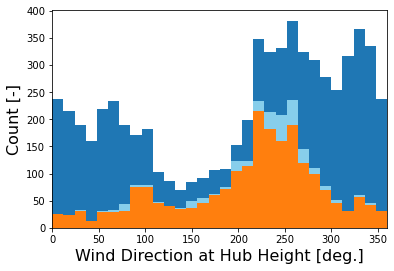

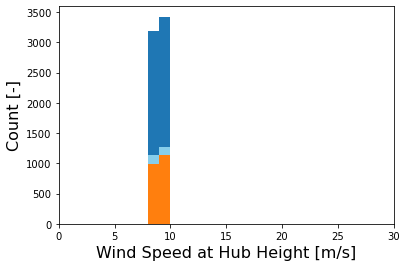

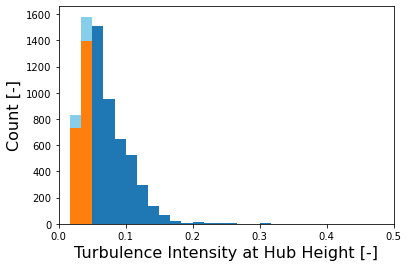

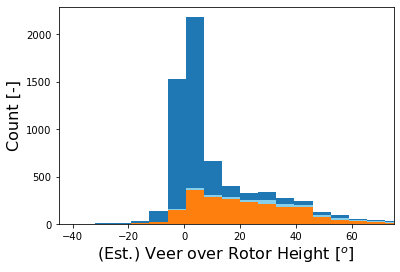

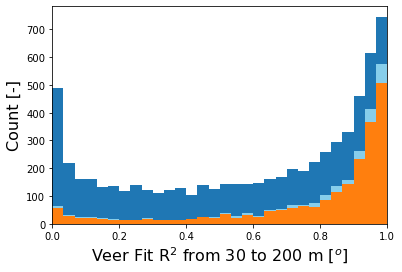

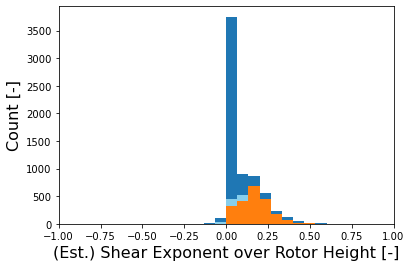

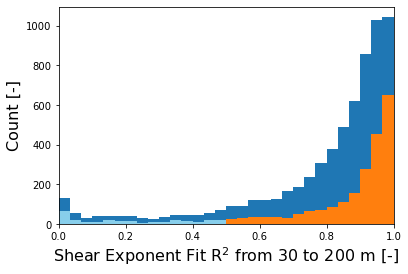

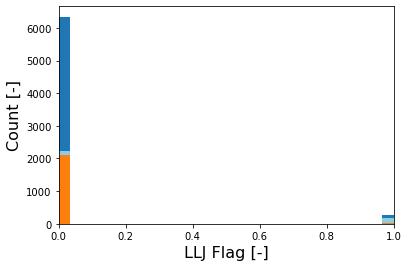

In [20]:
# highlight the data filtered by ti_range and also other filters

# plot hub-height wind direction histogram
plt.figure()
plt.hist(wind_direction_hh[keepIndex_onlyws],binNums,range=[0, 360]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why you must specify range or remove nans using "hist"
plt.hist(wind_direction_hh[keepIndex_onlywsANDti],binNums,range=[0, 360], color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why you must specify range or remove nans using "hist"
plt.hist(wind_direction_hh[keepIndex],binNums,range=[0, 360]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why you must specify range or remove nans using "hist"
plt.xlabel('Wind Direction at Hub Height [deg.]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 360])
#plt.ylim([0, 180])
plt.show()

# plot hub-height wind speed histogram
plt.figure()
plt.hist(wind_speed_hh[keepIndex_onlyws],binNums,range=[0, 30])
plt.hist(wind_speed_hh[keepIndex_onlywsANDti],binNums,range=[0, 30], color='skyblue')
plt.hist(wind_speed_hh[keepIndex],binNums,range=[0, 30])
plt.xlabel('Wind Speed at Hub Height [m/s]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 30])
#plt.ylim([0, 180])
plt.show()

# plot hub-height TI histogram
plt.figure()
plt.hist(turbulence_intensity_hh[keepIndex_onlyws],binNums,range=[0, 0.5])
plt.hist(turbulence_intensity_hh[keepIndex_onlywsANDti],binNums,range=[0, 0.5], color='skyblue')
plt.hist(turbulence_intensity_hh[keepIndex],binNums,range=[0, 0.5])
plt.xlabel('Turbulence Intensity at Hub Height [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 0.5])
#plt.ylim([0, 180])
plt.show()

# plot veer histogram
plt.figure()
plt.hist(veer[keepIndex_onlyws],binNums,range=[-45, 150]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(veer[keepIndex_onlywsANDti],binNums,range=[-45, 150], color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(veer[keepIndex],binNums,range=[-45, 150]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('(Est.) Veer over Rotor Height [$^o$]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([-45, 75])
#plt.ylim([0, 180])
plt.show()

# plot veer rsquared histogram
plt.figure()
plt.hist(veer_rsquared[keepIndex_onlyws],binNums,range=[0, 1]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(veer_rsquared[keepIndex_onlywsANDti],binNums,range=[0, 1], color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(veer_rsquared[keepIndex],binNums,range=[0, 1]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('Veer Fit R$^{2}$ from 30 to 200 m [$^o$]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 1])
#plt.ylim([0, 180])
plt.show()

# plot shear exponent histogram
plt.figure()
plt.hist(shear[keepIndex_onlyws],binNums,range=[-1, 1]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(shear[keepIndex_onlywsANDti],binNums,range=[-1, 1], color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(shear[keepIndex],binNums,range=[-1, 1]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('(Est.) Shear Exponent over Rotor Height [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([-1, 1])
#plt.ylim([0, 180])
plt.show()

# plot shear exponent rsquared histogram
plt.figure()
plt.hist(shear_rsquared[keepIndex_onlyws],binNums,range=[0, 1]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(shear_rsquared[keepIndex_onlywsANDti],binNums,range=[0, 1], color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(shear_rsquared[keepIndex],binNums,range=[0, 1]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('Shear Exponent Fit R$^{2}$ from 30 to 200 m [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 1])
#plt.ylim([0, 180])
plt.show()

# plot LLJ flag histogram
plt.figure()
plt.hist(LLJ_flag[keepIndex_onlyws],binNums,range=[0, 1]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(LLJ_flag[keepIndex_onlywsANDti],binNums,range=[0, 1], color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.hist(LLJ_flag[keepIndex],binNums,range=[0, 1]) # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('LLJ Flag [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 1])
#plt.ylim([0, 180])
plt.show()

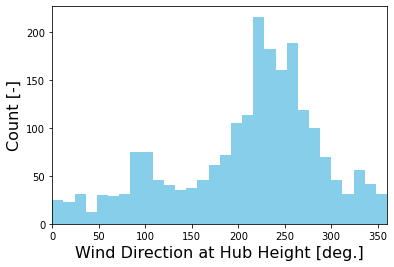

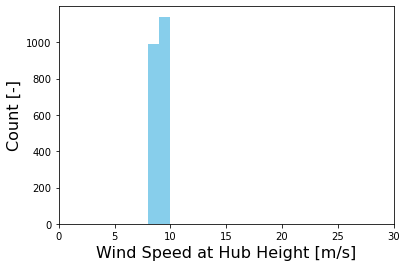

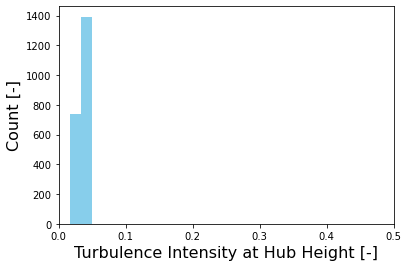

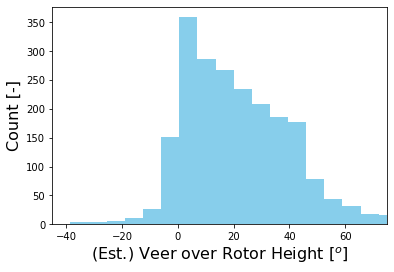

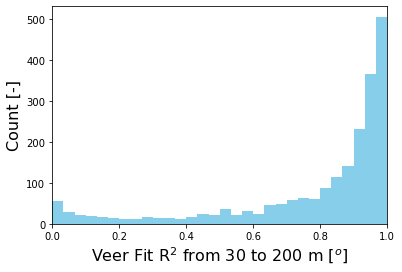

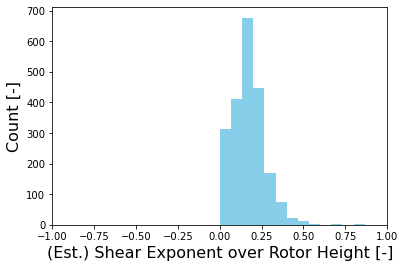

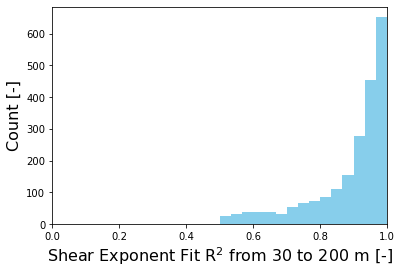

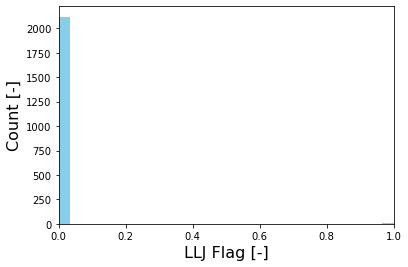

In [21]:
# highlight only the filtered data

# plot hub-height wind direction histogram
plt.figure()
plt.hist(wind_direction_hh[keepIndex],binNums,range=[0, 360], color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why you must specify range or remove nans using "hist"
plt.xlabel('Wind Direction at Hub Height [deg.]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 360])
#plt.ylim([0, 180])
plt.show()

# plot hub-height wind speed histogram
plt.figure()
plt.hist(wind_speed_hh[keepIndex],binNums,range=[0, 30], color='skyblue')
plt.xlabel('Wind Speed at Hub Height [m/s]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 30])
#plt.ylim([0, 180])
plt.show()

# plot hub-height TI histogram
plt.figure()
plt.hist(turbulence_intensity_hh[keepIndex],binNums,range=[0, 0.5], color='skyblue')
plt.xlabel('Turbulence Intensity at Hub Height [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 0.5])
#plt.ylim([0, 180])
plt.show()

# plot veer histogram
plt.figure()
plt.hist(veer[keepIndex],binNums,range=[-45, 150], color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('(Est.) Veer over Rotor Height [$^o$]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([-45, 75])
#plt.ylim([0, 180])
plt.show()

# plot veer rsquared histogram
plt.figure()
plt.hist(veer_rsquared[keepIndex],binNums,range=[0, 1], color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('Veer Fit R$^{2}$ from 30 to 200 m [$^o$]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 1])
#plt.ylim([0, 180])
plt.show()

# plot shear exponent histogram
plt.figure()
plt.hist(shear[keepIndex],binNums,range=[-1, 1], color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('(Est.) Shear Exponent over Rotor Height [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([-1, 1])
#plt.ylim([0, 180])
plt.show()

# plot shear exponent rsquared histogram
plt.figure()
plt.hist(shear_rsquared[keepIndex],binNums,range=[0, 1], color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('Shear Exponent Fit R$^{2}$ from 30 to 200 m [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 1])
#plt.ylim([0, 180])
plt.show()

# plot LLJ flag histogram
plt.figure()
plt.hist(LLJ_flag[keepIndex],binNums,range=[0, 1], color='skyblue') # see https://github.com/matplotlib/matplotlib/issues/6483 for why the nan removal is necessary...
plt.xlabel('LLJ Flag [-]', fontsize = 16)
plt.ylabel('Count [-]', fontsize = 16)
plt.xlim([0, 1])
#plt.ylim([0, 180])
plt.show()

## Compare to AMR Simulation

In [22]:
target = {}
target['hh']    = 150.0    # Hubheight
turbineD        = 240.0     # turbine diameter

#tavg            = [43925.0, 44825.0]
#amrdir          = '/nscratch/kbrown1/Advanced_Control/AMR/Precursors/TwoTurbine/Offshore_MedTI_Precursor_Coarse/post_processing/'
#amrdir          = '/tscratch/kbrown1/Advanced_Control/AMR/Precursor_Runs/Precursors/TwoTurbine/Offshore_MedTI_Precursor_Coarse/post_processing/'

tavg            = [27495.50, 27495.50+900]
amrdir          = './'
probefile       = amrdir+'/metmast_100000.nc'
zprobes         = list(np.linspace(0,500,150))


In [23]:
 def getMeanSTD(fulldata, zlist, tavg=[]):
    meanvec=[]
    stdvec=[]
    maxvec=[]
    minvec=[]
    WShmeanvec=[]
    WShstdvec=[]
    WShmaxvec=[]
    WShminvec=[]
    WDhmeanvec=[]
    WDhstdvec=[]
    WDhmaxvec=[]
    WDhminvec=[]
    Uhmeanvec=[]
    Uhstdvec=[]
    Uhmaxvec=[]
    Uhminvec=[]
    Vhmeanvec=[]
    Vhstdvec=[]
    Vhmaxvec=[]
    Vhminvec=[]
    Whmeanvec=[]
    Whstdvec=[]
    Whmaxvec=[]
    Whminvec=[]    
    TIhmeanvec=[]
    #TIhstdvec=[]
    #TIhmaxvec=[]
    #TIhminvec=[]
    for z in zlist:
        dat = fulldata[np.around(fulldata[:,3],3)==np.around(z,3),:]
        if len(tavg)==0:
            tavg=[np.min(dat[:,0])-9999, np.max(dat[:,0])+999]
        filtert=((tavg[0]<=dat[:,0]) & (dat[:,0] <= tavg[1]))
        filterdat=dat[filtert,:]        
        meanvec.append(np.mean(filterdat[:,1:],axis=0))
        maxvec.append(np.max(filterdat[:,1:],axis=0))
        minvec.append(np.min(filterdat[:,1:],axis=0))
        # WS
        WSh=np.sqrt(filterdat[:,4]**2 + filterdat[:,5]**2)      
        WShmeanvec.append(np.mean(WSh,axis=0))
        WShstdvec.append(np.std(WSh,axis=0)**2)
        WShmaxvec.append(np.max(WSh))
        WShminvec.append(np.min(WSh))
        # WD
        WDh=np.arctan2(-filterdat[:,5], filterdat[:,4])*180/np.pi+180      
        WDhmeanvec.append(np.mean(WDh,axis=0))
        WDhstdvec.append(np.std(WDh,axis=0)**2)
        WDhmaxvec.append(np.max(WDh))
        WDhminvec.append(np.min(WDh))
        # U
        Uh=filterdat[:,4]     
        Uhmeanvec.append(np.mean(Uh,axis=0))
        Uhstdvec.append(np.std(Uh,axis=0)**2)
        Uhmaxvec.append(np.max(Uh))
        Uhminvec.append(np.min(Uh))
        # V
        Vh=filterdat[:,5]     
        Vhmeanvec.append(np.mean(Vh,axis=0))
        Vhstdvec.append(np.std(Vh,axis=0)**2)
        Vhmaxvec.append(np.max(Vh))
        Vhminvec.append(np.min(Vh))
        # W
        Wh=filterdat[:,6]     
        Whmeanvec.append(np.mean(Wh,axis=0))
        Whstdvec.append(np.std(Wh,axis=0)**2)
        Whmaxvec.append(np.max(Wh))
        Whminvec.append(np.min(Wh))
        # u'
        uu=np.mean((Uh-np.mean(Uh,axis=0))**2)
        # v'
        vv=np.mean((Vh-np.mean(Vh,axis=0))**2)
        # w'
        ww=np.mean((Wh-np.mean(Wh,axis=0))**2)
        #TIh=np.sqrt(2./3.*0.5*(uu+vv+ww))/np.mean(WSh,axis=0)
        #TIh=np.std(WSh)/np.mean(WSh)
        TIh=np.sqrt(uu+vv)/np.mean(WSh,axis=0)
        TIhmeanvec.append(TIh)
        #TIhstdvec.append(np.std(TIh,axis=0)**2)
        #TIhmaxvec.append(np.max(TIh))
        #TIhminvec.append(np.min(TIh))
        #print([z,np.std(np.sqrt(filterdat[:,4]**2 + filterdat[:,5]**2))/np.mean(np.sqrt(filterdat[:,4]**2 + filterdat[:,5]**2))])
    return meanvec, stdvec, maxvec, WShmeanvec, WShstdvec, WShmaxvec, WShminvec, WDhmeanvec, WDhstdvec, WDhmaxvec, WDhminvec, TIhmeanvec#, TIhstdvec, TIhmaxvec, TIhminvec

In [24]:
 # Load the data
ncdata   = Dataset(probefile,'r')
numPoints = len(ncdata['metmast_T1']['coordinates'][:,1])
numTime   = len(ncdata['time'][:])

fullData = np.zeros((numTime*numPoints,7))
time_values = ncdata['time']
coordinates = ncdata['metmast_T1']['coordinates']
velocityx   = ncdata['metmast_T1']['velocityx']
velocityy   = ncdata['metmast_T1']['velocityy']
velocityz   = ncdata['metmast_T1']['velocityz']

for i in range(numTime):
    fullData[i*numPoints:(i+1)*numPoints, 0] = time_values[i]
    fullData[i*numPoints:(i+1)*numPoints, 1:4] = coordinates[:, :3]
    fullData[i*numPoints:(i+1)*numPoints, 4] = velocityx[i,:]
    fullData[i*numPoints:(i+1)*numPoints, 5] = velocityy[i,:]
    fullData[i*numPoints:(i+1)*numPoints, 6] = velocityz[i,:]

In [25]:
 # Extract the profile data
probemeanvec, stdvec, maxvec, WShmeanvec, WShstdvec, WShmaxvec, WShminvec, WDhmeanvec, WDhstdvec, WDhmaxvec, WDhminvec, TIhmeanvec = getMeanSTD(fullData, zprobes, tavg=tavg)
#print("%10s %10s %10s %10s %10s %10s %10s %10s"%('z', 'avg(WSh)', 'min(WSh)','max(WSh)', 'avg(WDh)', 'min(WDh)','max(WDh)','TIh'))
#for zi, z in enumerate(zprobes):
#    print("%10f %10f %10f %10f %10f %10f %10f %10f"%(z, WShmeanvec[zi], WShminvec[zi], WShmaxvec[zi], WDhmeanvec[zi], WDhminvec[zi], WDhmaxvec[zi], TIhmeanvec[zi]))
    
with open("AMRWIND_MedWS_MedTI_metmast.dat", 'w') as f:
    f.write("# %10s %10s %10s %10s %10s %10s %10s %10s\n"%('z', 'avg(WSh)', 'min(WSh)','max(WSh)', 'avg(WDh)', 'min(WDh)','max(WDh)','TIh'))
    for zi, z in enumerate(zprobes):
        f.write("%10f %10f %10f %10f %10f %10f %10f %10f\n"%(z, WShmeanvec[zi], WShminvec[zi], WShmaxvec[zi], WDhmeanvec[zi], WDhminvec[zi], WDhmaxvec[zi], TIhmeanvec[zi]))

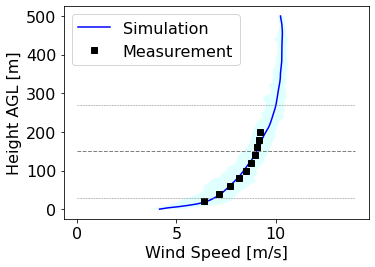

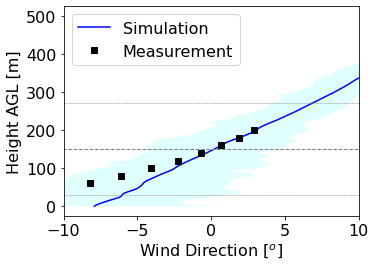

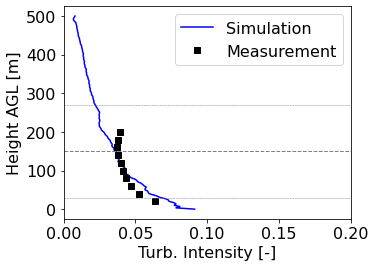

In [26]:
# compare to measurement
# plot wind speed traces
plt.figure(figsize=(5.5, 4))
plt.rc('font', size=16)
# Plot the data and simulation profiles
plt.fill_betweenx(zprobes, WShminvec, WShmaxvec, facecolor='lightcyan')
plt.plot(WShmeanvec, zprobes,  color='b',  label='Simulation')
plt.plot(WS_mean[~np.isnan(WS_mean)], heights[~np.isnan(WS_mean)], 's', color='k', label='Measurement')
# Plot the turbine dimensions
plt.hlines(target['hh'], 0,              14, linestyles='dashed', color='gray', linewidth=1.0) # Plot the HH line
plt.hlines(target['hh']+0.5*turbineD, 0, 14, linestyles='dashed', color='gray', linewidth=0.5) # Plot the rotor tip
plt.hlines(target['hh']-0.5*turbineD, 0, 14, linestyles='dashed', color='gray', linewidth=0.5) # Plot the rotor tip
# Plot formatting
plt.xlabel('Wind Speed [m/s]', fontsize = 16)
plt.ylabel('Height AGL [m]', fontsize = 16)
plt.legend(loc = 'best')
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.xlim([0, 15])
#plt.ylim([0, 180])
plt.tight_layout()
plt.savefig('MeasVsSim_WindSpeed.svg', format='svg', dpi=1200)
plt.show()

# plot wind direction traces
plt.figure(figsize=(5.5, 4))
plt.rc('font', size=16)
# Plot the data and simulation profiles
WD_h = WDC_mean[~np.isnan(WDC_mean)][7]  # measured WD 
WDh = np.interp(160.,zprobes,WDhmeanvec)  # simulated WD 
DeltaWD = WDh-WD_h  # offset in WD to apply to simulation data
plt.fill_betweenx(zprobes, WDhminvec-DeltaWD, WDhmaxvec-DeltaWD, facecolor='lightcyan')
plt.plot(WDhmeanvec-DeltaWD, zprobes,  color='b',  label='Simulation')
plt.plot(WDC_mean[~np.isnan(WDC_mean)], heights[~np.isnan(WDC_mean)], 's', color='k', label='Measurement')
# Plot the turbine dimensions
plt.hlines(target['hh'], -360,              360, linestyles='dashed', color='gray', linewidth=1.0) # Plot the HH line
plt.hlines(target['hh']+0.5*turbineD, -360, 360, linestyles='dashed', color='gray', linewidth=0.5) # Plot the rotor tip
plt.hlines(target['hh']-0.5*turbineD, -360, 360, linestyles='dashed', color='gray', linewidth=0.5) # Plot the rotor tip
# Plot formatting
plt.xlabel('Wind Direction [$^o$]', fontsize = 16)
plt.ylabel('Height AGL [m]', fontsize = 16)
plt.legend(loc = 2)
plt.xlim([-10, 10])
#plt.ylim([0, 180])
plt.tight_layout()
plt.savefig('MeasVsSim_WindDirection.svg', format='svg', dpi=1200)
plt.show()

# plot turbulence intensity traces
plt.figure(figsize=(5.5, 4))
plt.rc('font', size=16)
# Plot the data and simulation profiles
#plt.fill_betweenx(zprobes, WShminvec, WShmaxvec, facecolor='lightcyan')
plt.plot(TIhmeanvec, zprobes,  color='b',  label='Simulation')
#plt.plot([TI_25_target_conventionalDefinition,TI_60_target_conventionalDefinition], [25,60], 's', color='k', label='Measurement')
#plt.plot(TI_mean, [25,60], 's', color='k', label='Measurement')
plt.plot(TI_mean[~np.isnan(TI_mean)], heights[~np.isnan(TI_mean)], 's', color='k', label='Measurement')
# Plot the turbine dimensions
plt.hlines(target['hh'], 0,              14, linestyles='dashed', color='gray', linewidth=1.0) # Plot the HH line
plt.hlines(target['hh']+0.5*turbineD, 0, 14, linestyles='dashed', color='gray', linewidth=0.5) # Plot the rotor tip
plt.hlines(target['hh']-0.5*turbineD, 0, 14, linestyles='dashed', color='gray', linewidth=0.5) # Plot the rotor tip
# Plot formatting
plt.xlabel('Turb. Intensity [-]', fontsize = 16)
plt.ylabel('Height AGL [m]', fontsize = 16)
plt.legend(loc = 'best')
plt.xlim([0, 0.2])
#plt.ylim([0, 180])
plt.tight_layout()
plt.savefig('MeasVsSim_TurbInt.svg', format='svg', dpi=1200)
plt.show()
